# Homework Assignment 7

**Question 1:** Select two books and construct networks of people and locations, i.e. each link is between a a person and a location (20pt). Visualize the network using Cytoscape or Gephi (20pt).


Package setup

In [14]:
!pip install turicreate
!pip install kaggle 
!pip install gensim
!pip install pyLDAvis
!pip install spaCy
!pip install afinn
!pip install nltk
!pip install plotly_express

import nltk
nltk.download('stopwords')
nltk.download('punkt')

!python -m spacy download en_core_web_lg # Important! you need to restart runtime after install

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 19.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=afe091e566d0cbe348fb40b2924346be78842235ad26432a7f236f32b8992536
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=7f4687efff1e59c0593c394164779ed1bdc19a1b60260cc65ffb2cab5b10ab34
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_l

In [13]:
!mkdir /root/.kaggle/
import json
import os

# Installing the Kaggle package
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

!mkdir ./datasets
!mkdir ./datasets/dickens
!kaggle datasets download fuzzyfroghunter/dickens -p ./datasets/
!unzip ./datasets/dickens.zip  -d ./datasets/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets’: File exists
  0% 0.00/9.28M [00:00<?, ?B/s]
100% 9.28M/9.28M [00:00<00:00, 85.3MB/s]
Archive:  ./datasets/dickens.zip
  inflating: ./datasets/dickens/1289-0.txt  
  inflating: ./datasets/dickens/1400-0.txt  
  inflating: ./datasets/dickens/1467-0.txt  
  inflating: ./datasets/dickens/27924-0.txt  
  inflating: ./datasets/dickens/564-0.txt  
  inflating: ./datasets/dickens/580-0.txt  
  inflating: ./datasets/dickens/644-0.txt  
  inflating: ./datasets/dickens/650-0.txt  
  inflating: ./datasets/dickens/653-0.txt  
  inflating: ./datasets/dickens/675-0.txt  
  inflating: ./datasets/dickens/678-0.txt  
  inflating: ./datasets/dickens/700-0.txt  
  inflating: ./datasets/dickens/766-0.txt  
  inflating: ./datasets/dickens/786-0.txt  
  inflating: ./datasets/dickens/807-0.txt  
  inflating: ./datasets/dickens/882-0.txt  
  inflating: ./datasets/dickens/883-0.txt  
  inflating: ./datasets

In [0]:
import spacy
nlp = spacy.load('en_core_web_lg')
datasets_path = "./datasets/dickens"
oliver_path = f"{datasets_path}/pg730.txt"
traveller_path = f"{datasets_path}/914-0.txt" 	

def get_entites_dict_from_text(text):
    entities_dict= {}
    #using spaCy to get entities
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        e = entity.text.lower()
        if  label not in entities_dict:
            entities_dict[label] = {}
        if e not in entities_dict[label]:
            entities_dict[label][e] = 0
        entities_dict[label][e] += 1
    return entities_dict

def get_book_entities(path, person_min_times, other_entities_min_times=3):
    txt = open(path,"r", encoding="utf8", errors="ignore").read()
    txt = txt.replace("\n", " ")
    doc = nlp(txt)
    d = get_entites_dict_from_text(txt) 
    entities_dict = {}
    for k in d.keys():
        min_times = other_entities_min_times
        if k == "PERSON":
            min_times = person_min_times
        entity_dict = {k:v for k,v in d[k].items() if v>min_times}
        entities_dict[k] = entity_dict
    return entities_dict

A link in the network will be between people and location that appeared in the same paragraph.

In [49]:
from collections import Counter
import networkx as nx
from tqdm import tqdm

def get_persons_links(txt):
    links_set = set()
    doc = nlp(txt)
    pepole = [entity.text.lower().strip() for entity in doc.ents if entity.label_ == "PERSON"]
    location = [entity.text.lower().strip() for entity in doc.ents if entity.label_ == "GPE"]
    
    for e1 in pepole:
        for e2 in location:              
            links_set.add((e1,e2))

    return links_set

def get_pepole_location_graph(book_path):
 
  txt = open(book_path).read()
  paragraphs_list = txt.split("\n\n")
  links_dict = {}

  links_list = []    
  for para in tqdm(paragraphs_list):

    # for each paragraph each link counts only once
    links_list += list(get_persons_links(para))
  
  g = nx.Graph()
  conter = Counter(links_list)
  for e,count in conter.items():    
      v1,v2 = e
      g.add_edge(v1,v2, weight=count) 

  entities_dict = get_book_entities(book_path, 0)
  nodes_to_entities = {}
  pepoles = [entity.lower().strip() for entity in entities_dict['PERSON'].keys()]
  locations = [entity.lower().strip() for entity in entities_dict['GPE'].keys()]
  for pepole in pepoles:
    nodes_to_entities[pepole] = {'type': 'people'}
  for location in locations:
    nodes_to_entities[location] = {'type': 'location'} 
  nx.set_node_attributes(g, nodes_to_entities) 

  # hold only nodes that has type attribute
  g = g.subgraph([n for n, attrdict in g.nodes.items() if 'type' in attrdict])
  return g

oliver_g = get_pepole_location_graph(oliver_path)
print(nx.info(oliver_g))
nx.write_gml(oliver_g, "Oliver_Twist.gml")

100%|██████████| 4088/4088 [01:05<00:00, 62.37it/s]


Name: 
Type: Graph
Number of nodes: 65
Number of edges: 59
Average degree:   1.8154


In [52]:
traveller_g = get_pepole_location_graph(traveller_path)
print(nx.info(traveller_g))
nx.write_gml(traveller_g, "The_Uncommercial_Traveller.gml")

100%|██████████| 1344/1344 [00:37<00:00, 36.08it/s]


Name: 
Type: Graph
Number of nodes: 265
Number of edges: 227
Average degree:   1.7132


Graph pepole-location for Oliver Twist [here](https://drive.google.com/open?id=1wKSy-fIq5ndlLnhpiBuddUEMT0O2so7J), 
Graph pepole-location for The Uncommercial Traveller [here](https://drive.google.com/open?id=1rDH8ba8Zn1swsqjD4LUtlfV7XXTbAxi9)


**Question 2:** Use the [Friends TV Show Transcript](https://www.kaggle.com/ryanstonebraker/friends-transcript)
to create and evaluate a classifier that given a line of text can predict
 who is the "friend" that said it (20pt). Using sentiment analysis identify who are the most and less friendly friends (20pt). Construct a classifier that can be given several text lines (quotes) from a specific episode that will predict the episode's season number (20pt).

In [53]:
!mkdir /root/.kaggle/
import json
import os

# Installing the Kaggle package
!pip install kaggle 
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

!mkdir ./datasets
!mkdir ./datasets/friends
!kaggle datasets download ryanstonebraker/friends-transcript -p ./datasets/
!unzip ./datasets/friends-transcript.zip -d ./datasets/friends/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/friends’: File exists
friends-transcript.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./datasets/friends-transcript.zip
replace ./datasets/friends/friends_quotes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
!kaggle datasets list -s Friends

ref                                                     title                                              size  lastUpdated          downloadCount  
------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
hwassner/TwitterFriends                                 Twitter Friends                                   175MB  2016-09-02 13:28:00           2098  
rezaghari/friends-series-dataset                        Friends Series Dataset                             20KB  2020-04-26 04:54:19             31  
delayedkarma/fantasy-premier-league-20182019            Fantasy Premier League (FPL) 2018-2019            143KB  2018-11-23 22:50:17           1985  
sogun3/uspollution                                      U.S. Pollution Data                                26MB  2016-11-04 17:32:56          14549  
doaaalsenani/usa-cers-dataset                           US Cars Dataset                             

In [54]:
import pandas as pd
import turicreate as tc
data_path = './datasets/friends/friends_quotes.csv'

friends_df = pd.read_csv(data_path)
friends_sf =tc.SFrame(friends_df)
friends_df.head(10)

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
5,Monica,1.0,Monica Gets A Roommate,"Okay, everybody relax. This is not even a date...",5.0,1.0
6,Chandler,1.0,Monica Gets A Roommate,Sounds like a date to me.,6.0,1.0
7,Chandler,1.0,Monica Gets A Roommate,"Alright, so I'm back in high school, I'm stand...",7.0,1.0
8,All,1.0,Monica Gets A Roommate,"Oh, yeah. Had that dream.",8.0,1.0
9,Chandler,1.0,Monica Gets A Roommate,"Then I look down, and I realize there's a phon...",9.0,1.0


In [5]:
# check how many authors exist
import turicreate.aggregate as agg
friends_sf['quote'] = friends_sf['quote'].apply(lambda x: x.lower())
friends_sf['author'] = friends_sf['author'].apply(lambda x: x.lower())
popolar_author = friends_sf.groupby('author', {'count': agg.COUNT()}).sort('count', ascending = False)
print('The autors popularity by quate count: ')
popolar_author.print_rows(10)
main_authors = popolar_author['author'][:6]
print('The main author selected are: {} '.format(main_authors))

The autors popularity by quate count: 
+----------+-------+
|  author  | count |
+----------+-------+
|  rachel  |  8956 |
|   ross   |  8920 |
| chandler |  8180 |
|  monica  |  8175 |
|   joey   |  8015 |
|  phoebe  |  7260 |
|   mike   |  351  |
|   all    |  330  |
| richard  |  256  |
|  janice  |  214  |
+----------+-------+
[960 rows x 2 columns]

The main author selected are: ['rachel', 'ross', 'chandler', 'monica', 'joey', 'phoebe'] 


Let's add some Ngrams features

In [0]:
main_friends_sf = friends_sf.filter_by(main_authors, 'author') 
print('main friends quote count is: {}'.format(main_friends_sf.shape[0]))
main_friends_sf['words_1grams'] = tc.text_analytics.count_ngrams(main_friends_sf['quote'], n=1, method='word')
main_friends_sf['words_2grams'] = tc.text_analytics.count_ngrams(main_friends_sf['quote'], n=2, method='word')
main_friends_sf.materialize()

Let's add some sentiment fearures

In [0]:
from afinn import Afinn
afinn_text = Afinn()
main_friends_sf['afinn_score_text'] = main_friends_sf['quote'].apply(lambda t: afinn_text.score(t))

In [20]:
test, train  = main_friends_sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )

Train size 39506
Test size: 10000


In [21]:
features_list = ['words_1grams', 'words_2grams', 'afinn_score_text']
author_cls = tc.classifier.create(train,features=features_list, target="author")

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37530

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 139045

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.113643     | 0.245830          | 0.246964            | 1.769157          | 1.772667            |

| 2         | 2.203906     | 0.255609          | 0.256073            | 1.753560          | 1.762867            |

| 3         | 3.285516     | 0.261657          | 0.262146            | 1.741417          | 1.754528            |

| 4         | 4.392232     | 0.272289          | 0.267713            | 1.730952          | 1.746618            |

| 5         | 5.473140     | 0.275939          | 0.275304            | 1.722126          | 1.739970            |

| 10        | 10.874623    | 0.311644          | 0.277834            | 1.685577          | 1.719668            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 37530

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 139045

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.934827     | 0.242579          | 0.238360            | 1.740337          | 1.754628            |

| 2         | 1.865689     | 0.253024          | 0.248482            | 1.736650          | 1.750276            |

| 3         | 2.767274     | 0.255049          | 0.250000            | 1.736381          | 1.751143            |

| 4         | 3.689589     | 0.257288          | 0.251012            | 1.735305          | 1.751366            |

| 5         | 4.599633     | 0.259286          | 0.257085            | 1.734785          | 1.749811            |

| 10        | 9.080833     | 0.261871          | 0.259109            | 1.733527          | 1.748146            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 37530

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 139045

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 1.102469     | 0.245830          | 0.246964            | 1.734170          | 1.747313            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 37530

Number of classes           : 6

Number of feature columns   : 3

Number of unpacked features : 139045

Number of coefficients      : 695230

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.568543     | 0.740661          | 0.294028            |

| 1         | 4        | 1.000000  | 29.427601    | 0.817026          | 0.322368            |

| 2         | 5        | 1.000000  | 59.140247    | 0.844658          | 0.309717            |

| 3         | 6        | 1.000000  | 90.195861    | 0.864402          | 0.302632            |

| 4         | 7        | 1.000000  | 119.825255   | 0.876126          | 0.301619            |

| 6         | 9        | 1.000000  | 179.010353   | 0.888782          | 0.289980            |

| 7         | 10       | 1.000000  | 208.407686   | 0.892273          | 0.286943            |

| 8         | 11       | 1.000000  | 238.403463   | 0.894724          | 0.285425            |

| 9         | 12       | 1.000000  | 267.860212   | 0.896323          | 0.278340            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.277834008097166
PROGRESS: RandomForestClassifier          : 0.2591093117408907
PROGRESS: DecisionTreeClassifier          : 0.24696356275303644
PROGRESS: LogisticClassifier              : 0.2783400809716599
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.


In [22]:
author_results = author_cls.evaluate(test)
author_results

{'accuracy': 0.2815, 'auc': 0.608398493767518, 'confusion_matrix': Columns:
 	target_label	str
 	predicted_label	str
 	count	int
 
 Rows: 36
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |   chandler   |      rachel     |  272  |
 |     ross     |      phoebe     |  147  |
 |     ross     |     chandler    |  344  |
 |     ross     |       joey      |  220  |
 |    monica    |      phoebe     |  157  |
 |    monica    |      monica     |  444  |
 |    phoebe    |       ross      |  226  |
 |    phoebe    |      rachel     |  269  |
 |   chandler   |      monica     |  236  |
 |    phoebe    |       joey      |  140  |
 +--------------+-----------------+-------+
 [36 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'f1_score': 0.2785056649032068, 'log_loss': 4.193237399826535, 'precision': 0.28

In [25]:
author_results['confusion_matrix'].print_rows(40)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|   chandler   |      rachel     |  272  |
|     ross     |      phoebe     |  147  |
|     ross     |     chandler    |  344  |
|     ross     |       joey      |  220  |
|    monica    |      phoebe     |  157  |
|    monica    |      monica     |  444  |
|    phoebe    |       ross      |  226  |
|    phoebe    |      rachel     |  269  |
|   chandler   |      monica     |  236  |
|    phoebe    |       joey      |  140  |
|     joey     |       joey      |  410  |
|    rachel    |       ross      |  270  |
|     joey     |     chandler    |  378  |
|     ross     |      rachel     |  311  |
|     joey     |      phoebe     |  157  |
|     joey     |      rachel     |  234  |
|    rachel    |     chandler    |  325  |
|     ross     |      monica     |  237  |
|    monica    |     chandler    |  315  |
|   chandler   |       ross      |  259  |
|    monica

Let's look at authers sentiment:

Text(0.5, 1.0, 'Main Autors Positive Percent Quotes: ')

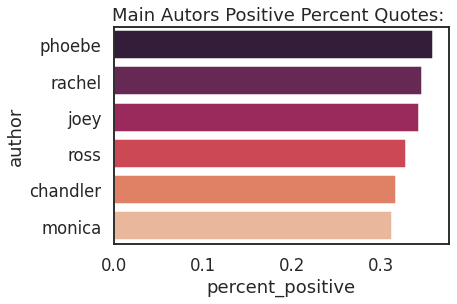

In [44]:
from afinn import Afinn
import plotly_express as px
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

main_friends_sf['pos_sentiment'] = main_friends_sf['afinn_score_text'].apply(lambda t: 1 if t>0 else 0)
main_friends_sf['neg_sentiment'] = main_friends_sf['afinn_score_text'].apply(lambda t: 1 if t<0 else 0)

sns.set(style="white", context="talk")

main_friends_sentiment_stats = main_friends_sf.groupby('author', {'positive_count':agg.SUM('pos_sentiment'),
                          'negative_count':agg.SUM('neg_sentiment'), 'all_quote_count':agg.COUNT()})
main_friends_sentiment_stats['percent_positive'] = main_friends_sentiment_stats.apply(lambda row: row['positive_count']/ row['all_quote_count'])
main_friends_sentiment_stats['percent_negative'] = main_friends_sentiment_stats.apply(lambda row: row['negative_count']/ row['all_quote_count'])
main_friends_positive = main_friends_sentiment_stats.sort("percent_positive", ascending=False)
df = main_friends_positive.to_dataframe()
sns.barplot(y=df['author'], x=df["percent_positive"], palette="rocket").set_title("Main Autors Positive Percent Quotes: ")

We can infer that Phoebe is the most friendly friend!

Text(0.5, 1.0, 'Main Autors Negative Percent Quotes: ')

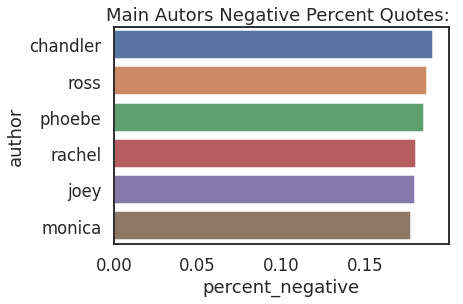

In [46]:
main_friends_positive = main_friends_sentiment_stats.sort("percent_negative", ascending=False)
df = main_friends_positive.to_dataframe()
sns.barplot(y=df['author'], x=df["percent_negative"], palette="deep").set_title("Main Autors Negative Percent Quotes: ")

We can infer that Chandler is the less friendly friend!

Let's create episode classifier

In [55]:
friends_sf

author,episode_number,episode_title,quote,quote_order,season
Monica,1.0,Monica Gets A Roommate,There's nothing to tell!He's just some guy I ...,0.0,1.0
Joey,1.0,Monica Gets A Roommate,"C'mon, you're going outwith the guy! There's ...",1.0,1.0
Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice.So does he have a hum ...",2.0,1.0
Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don'twant her to go through ...",4.0,1.0
Monica,1.0,Monica Gets A Roommate,"Okay, everybody relax.This is not even a date. ...",5.0,1.0
Chandler,1.0,Monica Gets A Roommate,Sounds like a date to me.,6.0,1.0
Chandler,1.0,Monica Gets A Roommate,"Alright, so I'm back inhigh school, I'm stan ...",7.0,1.0
All,1.0,Monica Gets A Roommate,"Oh, yeah. Had that dream.",8.0,1.0
Chandler,1.0,Monica Gets A Roommate,"Then I look down, and Irealize there's a ...",9.0,1.0


In [63]:
from afinn import Afinn
import turicreate.aggregate as agg
import seaborn as sns

season_episodes_count = friends_sf.groupby('season', {'episode_count': agg.COUNT_DISTINCT('episode_number')}).sort('season', ascending = True)
print('episodes distribution in seasons: ')
season_episodes_count.print_rows(10)

episodes distribution in seasons: 
+--------+---------------+
| season | episode_count |
+--------+---------------+
|  1.0   |       24      |
|  2.0   |       23      |
|  3.0   |       25      |
|  4.0   |       23      |
|  5.0   |       23      |
|  6.0   |       23      |
|  7.0   |       24      |
|  8.0   |       23      |
|  9.0   |       21      |
|  10.0  |       17      |
+--------+---------------+
[10 rows x 2 columns]



Lets select randomly percent of quotes from each episode, concat all the quots and extract sentiment and Ngram features. I will examine the results for 100%, 90%, 80%, 70%.

In [0]:
from afinn import Afinn
import random
def randomly_select_quotes(quotes_list, percent_to_select):
  random_select_n = int((float(percent_to_select)/100)*float(len(quotes_list)))
  return random.sample(quotes_list, random_select_n)


concat_quotes_for_episodes = friends_sf.groupby(['season', 'episode_number'], {'concat_quotes': agg.CONCAT('quote')})
list_of_percent_to_check = [100, 90, 80, 70]
afinn_text = Afinn()
for percent_to_select in list_of_percent_to_check:
  concat_quotes_for_episodes['selected_quotes_{}'.format(percent_to_select)] = concat_quotes_for_episodes['concat_quotes'].apply(lambda x: randomly_select_quotes(x, percent_to_select))
  concat_quotes_for_episodes['all_quotes_text_{}'.format(percent_to_select)] = concat_quotes_for_episodes['selected_quotes_{}'.format(percent_to_select)].apply(lambda x: "#".join(x))
  # feature extraction
  concat_quotes_for_episodes['afinn_score_text_{}'.format(percent_to_select)] = concat_quotes_for_episodes['all_quotes_text_{}'.format(percent_to_select)].apply(lambda t: afinn_text.score(t))
  concat_quotes_for_episodes['words_1grams_{}'.format(percent_to_select)] = tc.text_analytics.count_ngrams(concat_quotes_for_episodes['all_quotes_text_{}'.format(percent_to_select)], n=1, method='word', delimiters= ['#'])
  concat_quotes_for_episodes['words_2grams_{}'.format(percent_to_select)] = tc.text_analytics.count_ngrams(concat_quotes_for_episodes['all_quotes_text_{}'.format(percent_to_select)], n=2, method='word', delimiters= ['#'])
  concat_quotes_for_episodes.materialize()


In [76]:
concat_quotes_for_episodes['season'] = concat_quotes_for_episodes['season'].apply(lambda x: str(x))
test, train  = concat_quotes_for_episodes.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )

Train size 179
Test size: 47


In [83]:
cls_auc = {}
cls_auc_test_results = {}
for percent_to_select in list_of_percent_to_check:
  features_list = ['words_1grams', 'words_2grams', 'afinn_score_text']
  features_list = ['{}_{}'.format(feature, percent_to_select) for feature in features_list]  
  cls = tc.classifier.create(train,features=features_list, target="season")
  cls_results = cls.evaluate(test)
  cls_auc[percent_to_select] = cls_results['auc']
  cls_auc_test_results[percent_to_select] = cls_results

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 84507

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.465568     | 0.964706          | 0.111111            | 1.645055          | 2.260777            |

| 2         | 0.879288     | 0.988235          | 0.222222            | 1.253101          | 2.241431            |

| 3         | 1.330756     | 0.988235          | 0.222222            | 0.968645          | 2.181687            |

| 4         | 1.755053     | 0.994118          | 0.222222            | 0.768903          | 2.166892            |

| 5         | 2.192089     | 1.000000          | 0.222222            | 0.615341          | 2.171262            |

| 10        | 4.197270     | 1.000000          | 0.222222            | 0.238544          | 2.179245            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 84507

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.394934     | 0.811765          | 0.222222            | 0.922164          | 2.676691            |

| 2         | 0.750786     | 0.929412          | 0.222222            | 0.845119          | 2.393361            |

| 3         | 1.095645     | 0.929412          | 0.111111            | 0.837807          | 2.334359            |

| 4         | 1.455870     | 0.976471          | 0.111111            | 0.832102          | 2.281016            |

| 5         | 1.803450     | 0.988235          | 0.111111            | 0.830302          | 2.192080            |

| 10        | 3.584250     | 1.000000          | 0.222222            | 0.809258          | 2.088677            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 84507

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.458120     | 0.964706          | 0.111111            | 0.634405          | 2.413058            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 84507

Number of coefficients      : 760572

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.124582     | 1.000000          | 0.333333            |

| 1         | 3        | 1.000000  | 0.316624     | 1.000000          | 0.333333            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.2222222222222222
PROGRESS: RandomForestClassifier          : 0.2222222222222222
PROGRESS: DecisionTreeClassifier          : 0.1111111111111111
PROGRESS: LogisticClassifier              : 0.3333333333333333
PROGRESS: ---------------------------------------------
PROGRESS: Selecting LogisticClassifier based on validation set performance.
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 76242

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.431680     | 0.958824          | 0.333333            | 1.685745          | 2.061924            |

| 2         | 0.814319     | 0.994118          | 0.444444            | 1.276279          | 1.961720            |

| 3         | 1.215081     | 1.000000          | 0.444444            | 0.986358          | 1.858938            |

| 4         | 1.605031     | 1.000000          | 0.444444            | 0.781559          | 1.880619            |

| 5         | 1.987542     | 1.000000          | 0.444444            | 0.627823          | 1.848056            |

| 10        | 3.829621     | 1.000000          | 0.444444            | 0.252367          | 1.775542            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 76242

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.347169     | 0.717647          | 0.333333            | 1.091260          | 2.271245            |

| 2         | 0.665887     | 0.870588          | 0.444444            | 0.946428          | 1.929933            |

| 3         | 0.987397     | 0.911765          | 0.333333            | 0.901871          | 1.945198            |

| 4         | 1.298797     | 0.941176          | 0.333333            | 0.891369          | 1.846219            |

| 5         | 1.604204     | 0.947059          | 0.444444            | 0.895964          | 1.798408            |

| 10        | 3.137853     | 0.988235          | 0.222222            | 0.853013          | 1.859343            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 76242

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.413737     | 0.958824          | 0.333333            | 0.687767          | 2.013708            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 76242

Number of coefficients      : 686187

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.114005     | 1.000000          | 0.222222            |

| 1         | 3        | 1.000000  | 0.273364     | 1.000000          | 0.222222            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.4444444444444444
PROGRESS: RandomForestClassifier          : 0.2222222222222222
PROGRESS: DecisionTreeClassifier          : 0.3333333333333333
PROGRESS: LogisticClassifier              : 0.2222222222222222
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 68425

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.391618     | 0.900000          | 0.333333            | 1.729999          | 2.210406            |

| 2         | 0.767595     | 0.964706          | 0.222222            | 1.340094          | 2.228944            |

| 3         | 1.144383     | 0.976471          | 0.222222            | 1.058598          | 2.131906            |

| 4         | 1.521803     | 0.988235          | 0.222222            | 0.849081          | 2.094802            |

| 5         | 1.899110     | 1.000000          | 0.222222            | 0.691865          | 2.082839            |

| 10        | 3.653495     | 1.000000          | 0.444444            | 0.285801          | 1.952581            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 68425

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.319012     | 0.676471          | 0.444444            | 1.155528          | 2.091411            |

| 2         | 0.630511     | 0.841176          | 0.555556            | 1.043613          | 1.947288            |

| 3         | 0.941024     | 0.923529          | 0.555556            | 0.964312          | 2.038518            |

| 4         | 1.251405     | 0.947059          | 0.444444            | 0.956378          | 2.089367            |

| 5         | 1.557416     | 0.958824          | 0.555556            | 0.955585          | 2.030314            |

| 10        | 3.032452     | 0.994118          | 0.333333            | 0.926037          | 1.925988            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 68425

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.383478     | 0.900000          | 0.333333            | 0.815591          | 2.299826            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 68425

Number of coefficients      : 615834

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.110825     | 1.000000          | 0.333333            |

| 1         | 3        | 1.000000  | 0.266177     | 1.000000          | 0.333333            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.4444444444444444
PROGRESS: RandomForestClassifier          : 0.3333333333333333
PROGRESS: DecisionTreeClassifier          : 0.3333333333333333
PROGRESS: LogisticClassifier              : 0.3333333333333333
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 59242

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.328741     | 0.888235          | 0.222222            | 1.745295          | 2.130171            |

| 2         | 0.636534     | 0.988235          | 0.333333            | 1.355794          | 2.029087            |

| 3         | 0.938141     | 0.994118          | 0.333333            | 1.076242          | 1.922507            |

| 4         | 1.240828     | 0.994118          | 0.222222            | 0.877395          | 1.892329            |

| 5         | 1.568317     | 0.994118          | 0.222222            | 0.721946          | 1.850278            |

| 10        | 2.987252     | 1.000000          | 0.333333            | 0.302085          | 1.710304            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 59242

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.274823     | 0.729412          | 0.222222            | 1.111142          | 2.086048            |

| 2         | 0.524183     | 0.841176          | 0.222222            | 1.013646          | 2.064530            |

| 3         | 0.754827     | 0.923529          | 0.444444            | 1.020558          | 1.984324            |

| 4         | 1.021170     | 0.935294          | 0.444444            | 1.030903          | 1.813052            |

| 5         | 1.264571     | 0.952941          | 0.333333            | 1.024277          | 1.854424            |

| 10        | 2.489736     | 0.988235          | 0.333333            | 0.991199          | 1.941078            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 59242

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.535310     | 0.888235          | 0.222222            | 0.819935          | 1.972408            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 170

Number of classes           : 10

Number of feature columns   : 3

Number of unpacked features : 59242

Number of coefficients      : 533187

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.094359     | 1.000000          | 0.333333            |

| 1         | 3        | 1.000000  | 0.219209     | 1.000000          | 0.333333            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.3333333333333333
PROGRESS: RandomForestClassifier          : 0.3333333333333333
PROGRESS: DecisionTreeClassifier          : 0.2222222222222222
PROGRESS: LogisticClassifier              : 0.3333333333333333
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [84]:
cls_auc

{70: 0.6422774356481106,
 80: 0.6395943430742069,
 90: 0.6445606293876289,
 100: 0.6993983408348128}

We can see that the classifier with 100 percent of quotes in each episode got the best results for season classification 